In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt
import h5py

import torch
import torch.nn.functional as F

import lava.lib.dl.slayer as slayer
import torch
import torchvision
from lava.lib.dl import netx

# Dropout broke in PyTorch 1.11
if tuple(map(int, torch.__version__.split('.')[:2])) == (1, 11):
    print("WARNING: Dropout is bugged in PyTorch 1.11. Results may be worse.")
    dropout_fn = nn.Dropout
if tuple(map(int, torch.__version__.split('.')[:2])) >= (1, 12):
    dropout_fn = nn.Dropout1d
else:
    dropout_fn = nn.Dropout2d

# random_seed = 18
# import torch
# torch.manual_seed(random_seed)
# import random
# random.seed(random_seed)
import numpy as np
# np.random.seed(random_seed)


In [2]:
def split_train_val(train, val_split):
    train_len = int(len(train) * (1.0-val_split))
    train, val = torch.utils.data.random_split(
        train,
        (train_len, len(train) - train_len),
        generator=torch.Generator().manual_seed(42),
    )
    return train, val

In [3]:
# Get validation data
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        transforms.Lambda(lambda x: x.view(3, 1024).t())
    ])
transform_train = transform_test = transform

# Datasets
trainset = torchvision.datasets.CIFAR10(
    root='./data/cifar/', train=True, download=True, transform=transform_train)
trainset, val = split_train_val(trainset, val_split=0.1)

testset = torchvision.datasets.CIFAR10(
    root='./data/cifar/', train=False, download=True, transform=transform_test)

val_loader = torch.utils.data.DataLoader(dataset=val , batch_size=1, shuffle=True, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
label, data_sample = next(enumerate(val_loader))

inp_exp = 0
data_rescaled = torch.transpose(data_sample[0], -1,-2)
diff_inp = data_rescaled[:,:, 1:] - data_rescaled[:, :, :-1]
diff_inp = torch.from_numpy(np.concatenate((data_rescaled[:, :, :1], diff_inp), axis=2))
print(data_sample[1])

tensor([9])


In [5]:
d_model = 128

# inp_proj = torch.nn.Linear(3, d_model)
# data_proj = inp_proj(diff_inp.movedim(-1, 1)).movedim(1, -1)
# data_proj.shape



In [6]:
from lava.lib.dl.slayer.state_space_models.sCIFAR.network import SCIFARNetwork


# differences
n_states = 64
lava_dl_model = SCIFARNetwork(d_model=d_model, n_states=n_states)
lava_dl_model.load_state_dict(torch.load("4_layer.pt"))

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


<All keys matched successfully>

In [7]:
a = lava_dl_model(data_sample[0])

In [8]:
# lava_dl_model.export_hdf5("debug.net")
loaded_net =  netx.hdf5.Network(net_config='4_layer_cifar.net', input_message_bits=16, sparse_fc_layer=True, skip_layers=1)
# os.remove("debug.net")
print(loaded_net)

|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1| 8192|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1| 8192|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1| 8192|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1| 8192|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1|   10|     |     |     |     |     |Fa

In [9]:
# get output from loaded lava net
from lava.proc.io.source import RingBuffer as SourceBuffer
from lava.proc.io.sink import RingBuffer as SinkBuffer
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg, Loihi2HwCfg
from lava.proc.dense.process import Dense
from lava.proc.s4d.ncmodels import NcModelSigmaS4dDelta
from lava.proc.s4d.process import SigmaS4dDelta
from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter

# Enable SLURM, the workload manager used to distribute Loihi2 resources to users
os.environ['SLURM'] = '1'
os.environ['PARTITION'] = "oheogulch"
os.environ['LOIHI_GEN'] = "N3C1"

n_steps = 1024 + len(loaded_net)

spiker = SourceBuffer(data=diff_inp.detach().numpy().reshape(3,1024) * 2**inp_exp)
adapter_i = PyToNxAdapter(shape=(3,), num_message_bits=16)
adapter_o = NxToPyAdapter(shape=(10,), num_message_bits=16)
receiver = SinkBuffer(buffer = n_steps, shape=(10,))


spiker.s_out.connect(adapter_i.inp)
adapter_i.out.connect(loaded_net.inp)
loaded_net.out.connect(adapter_o.inp)
adapter_o.out.connect(receiver.a_in)

# exception_map = {SigmaS4dDelta : NcModelSigmaS4dDelta}
# run_cfg = Loihi2HwCfg(exception_proc_model_map=exception_map)

run_cfg = Loihi2HwCfg()

In [10]:
from lava.magma.compiler.subcompilers.nc.ncproc_compiler import CompilerOptions
CompilerOptions.verbose = True
sigma = np.zeros(n_steps)
S4state = np.zeros(n_steps)

for time_step in range(n_steps):
        spiker.run(
            condition=RunSteps(num_steps=1), run_cfg=Loihi2HwCfg()
        )    
received_data_lava = receiver.data.get()
spiker.stop()

Partitioning converged after iteration=7
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   2.93%|   0.06%|   0.00%|   3.09%|       1|
|   0.80%|  12.50%|   3.13%|  28.11%|   0.80%|   0.00%|  24.41%|       1|
|  51.20%|  12.50%|   1.54%|  25.20%|   0.39%|   0.00%|  61.76%|       3|
|   0.80%|  12.50%|  99.98%|   2.80%|  12.79%|   0.00%|  33.59%|       5|
|   0.80%|  12.50%|   3.13%|  27.32%|   0.80%|   0.00%|  23.78%|       1|
|  51.20%|  12.50%|   1.54%|  25.20%|   0.39%|   0.00%|  61.76%|       3|
|   0.80%|  12.50%|  99.98%|   2.80%|  12.79%|   0.00%|  33.59%|       5|
|   0.80%|  12.50%|   3.13%|  27.42%|   0.80%|   0.00%|  23.86%|       1|
|  51.20%|  12.50%|   1.54%|  25.20%|   0.39%|   0.00%|  61.76%|       3|
|   0.80%|  12.50%|  99.98%|   2.80%|  12.79%|   

/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


In [11]:
out_lava = (received_data_lava.astype(np.int32) << 8) >> 8

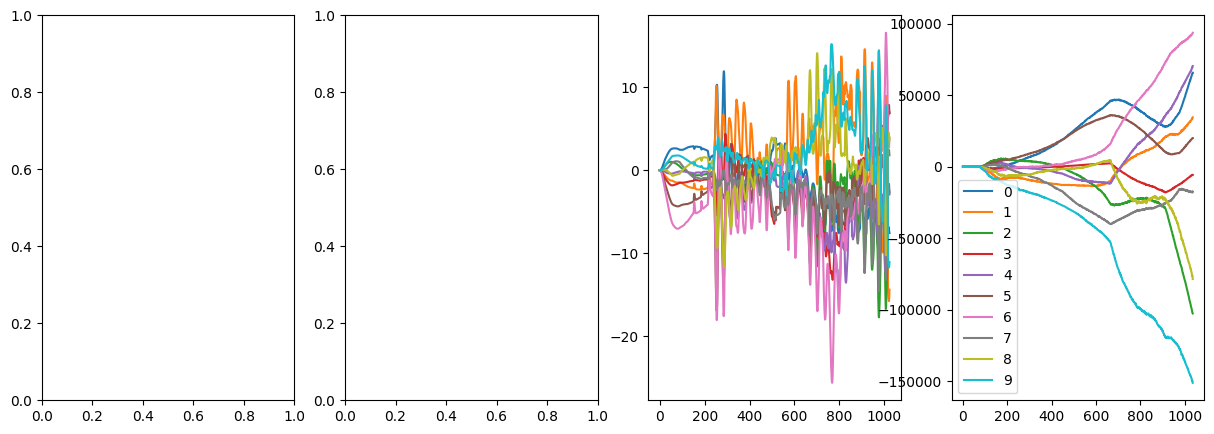

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
# axs[0].plot(np.cumsum(a[0].detach().numpy(), axis=1).T);
# axs[1].plot(np.cumsum(received_data_lava.astype(np.int16), axis=1)[:, :].T / 2**inp_exp);

axs[2].plot(a[0].detach().numpy().T);
axs[3].plot(out_lava.T, label=range(10))
plt.legend();

In [13]:
out_lava.mean(-1).argmax()

0

In [14]:
data_sample[1]

tensor([9])

In [15]:
a[0].mean(-1).argmax()

tensor(9)

In [ ]:
CompilerOptions.verbose = False

preds = []
preds_dl = []
tgts = []
for batch_idx, [inp, tgt] in enumerate(val_loader):
    
    inp_exp = 0
    data_rescaled = torch.transpose(inp, -1,-2)
    diff_inp = data_rescaled[:,:, 1:] - data_rescaled[:, :, :-1]
    diff_inp = torch.from_numpy(np.concatenate((data_rescaled[:, :, :1], diff_inp), axis=2))


    tgts.append(tgt.item())
    # lava_dl_model = SCIFARNetwork(d_model=d_model, n_states=n_states)
    # lava_dl_model.load_state_dict(torch.load("4_layer.pt"))
    # lava_dl_model.eval()
    
    out_dl = lava_dl_model(inp)
    pred_dl = out_dl[0].mean(-1).argmax().item()

    preds_dl.append(pred_dl)

    loaded_net =  netx.hdf5.Network(net_config='4_layer_cifar.net', input_message_bits=16, sparse_fc_layer=True, skip_layers=1)
    n_steps = 1024 + len(loaded_net)
    
    spiker = SourceBuffer(data=diff_inp.detach().numpy().reshape(3,1024) * 2**inp_exp)
    adapter_i = PyToNxAdapter(shape=(3,), num_message_bits=16)
    adapter_o = NxToPyAdapter(shape=(10,), num_message_bits=16)
    receiver = SinkBuffer(buffer = n_steps, shape=(10,))
    
    
    spiker.s_out.connect(adapter_i.inp)
    adapter_i.out.connect(loaded_net.inp)
    loaded_net.out.connect(adapter_o.inp)
    adapter_o.out.connect(receiver.a_in)
    run_cfg = Loihi2HwCfg()
    spiker.run(condition=RunSteps(num_steps=n_steps), run_cfg=Loihi2HwCfg()) 
    received_data_lava = receiver.data.get()
    spiker.stop()
    out_lava = (received_data_lava.astype(np.int32) << 8) >> 8
    pred_lava = out_lava.mean(-1).argmax()
    preds.append(pred_lava)

    
    print(tgt, pred_dl, pred_lava)
    if batch_idx > 100:
        break


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([3]) 6 2


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([3]) 0 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([9]) 7 0


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([8]) 8 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([1]) 9 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([4]) 2 5


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([1]) 1 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([4]) 4 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([7]) 7 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([0]) 8 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([0]) 0 6


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([2]) 3 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([4]) 4 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([2]) 2 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([5]) 7 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([8]) 8 0


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([1]) 1 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([5]) 6 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([4]) 7 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([9]) 9 6


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([7]) 2 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([6]) 6 2


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([0]) 0 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([2]) 2 2


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([2]) 2 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([7]) 0 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([0]) 0 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([5]) 3 8


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([8]) 8 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([7]) 4 6


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([0]) 9 6


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([1]) 1 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([2]) 2 5


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([7]) 4 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([6]) 3 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([6]) 6 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([7]) 7 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([4]) 4 6


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([1]) 1 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([4]) 4 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


tensor([9]) 0 4


/home/pweidel/lava-nc/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


In [ ]:
print(tgts, preds_dl, preds)
